# Diffusion on the edge - Part II: Maximal manifold exploration

In the previous part, we explored the basics of score-matching based diffusion models and continous-time stochastic processes.  
This follow up piece will walk through the basic ideas explored in the paper __paper_name_here__.

## Main concept

The paper introduces the concept of exploring the data manifold maximally by fine tuning a pre-learned diffusion model. Mathematically, the paper describes how diffusion models can miss some of the underlying data distribution. Our goal is to implement the described S-MEME algorithm and generate samples from low-density regions of the data manifold.

## Dataset

For simplicity, as we develop this implementation code we should have a simple and robust dataset on hand. 

Let's take as our fundamental data manifold all possible 2D-triangles based on distance. So each data point is a triplet of numbers, $(a, b, c)$ where the measurements $a, b, c$ are distances between points $A, B, C$ defined as $a = |AB|, b = |BC|, c = |CA|$. All of these points lie on some non-trivial submanifold of $\mathbb{R}^3$. For simplicity, let's also constrict the distances to be less than $1$. Therefore, the possible data points lie as a subset of the unit cube, $(a, b, c) \in [0, 1]^3$.

In [1]:
import torch
import torch.nn as nn
import torch.functional as F

import numpy as np
import pandas as pd
from diffusion_on_the_edge.stochastics import generate_trajectory, generate_sample_ou
from diffusion_on_the_edge.visualize import plot_multiple_1d_trajectories
from diffusion_on_the_edge.model import SimpleScoreNet

def sample_valid_triangle_sides(n_samples: int, seed: int = 42, sort_sides = True):
    """Sample valid triangle side lengths (a, b, c) in [0, 1] satisfying the triangle inequality."""
    np.random.seed(seed)
    samples = []
    while len(samples) < n_samples:
        a, b, c = np.random.rand(3)
        if (a + b > c) and (b + c > a) and (c + a > b):
            sample = tuple(sorted((a, b, c))) if sort_sides else (a, b, c)
            samples.append(sample)
    return np.array(samples)

def classify_triangle_sides(a, b, c, tol=1e-2):
    """Classify triangle type by side lengths: 'equilateral', 'isosceles', or 'scalene'."""
    sides = sorted([a, b, c])
    if np.isclose(sides[0], sides[1], atol=tol) and np.isclose(sides[1], sides[2], atol=tol):
        return 'equilateral'
    elif np.isclose(sides[0], sides[1], atol=tol) or np.isclose(sides[1], sides[2], atol=tol):
        return 'isosceles'
    else:
        return 'scalene'

def classify_triangle_angles(a, b, c, tol=1e-2):
    """Classify triangle type by angles: 'right', 'acute', or 'obtuse'."""
    sides = sorted([a, b, c])  # ensure c is the longest side
    a, b, c = sides
    cos_C = (a**2 + b**2 - c**2) / (2 * a * b)
    cos_C = np.clip(cos_C, -1, 1)  # numerical stability
    angle_C = np.arccos(cos_C) * 180 / np.pi  # degrees
    if np.isclose(angle_C, 90.0, atol=tol * 90):
        return 'right'
    elif angle_C < 90:
        return 'acute'
    else:
        return 'obtuse'

def generate_biased_triangle_dataset(n_samples=5000, side_bias=None, angle_bias=None, seed=42):
    """
    Generate a dataset of triangle side lengths with optional bias on side and angle types.
    side_bias: dict like {'equilateral': 0.02, 'isosceles': 0.18, 'scalene': 0.80}
    angle_bias: dict like {'right': 0.05, 'acute': 0.70, 'obtuse': 0.25}
    """
    all_samples = sample_valid_triangle_sides(n_samples * 5, seed=seed)
    df = pd.DataFrame(all_samples, columns=['a', 'b', 'c'])
    df['side_type'] = df.apply(lambda row: classify_triangle_sides(row['a'], row['b'], row['c']), axis=1)
    df['angle_type'] = df.apply(lambda row: classify_triangle_angles(row['a'], row['b'], row['c']), axis=1)
    
    if side_bias:
        biased_df = []
        for ttype, ratio in side_bias.items():
            subset = df[df['side_type'] == ttype]
            n_target = int(n_samples * ratio)
            sampled_subset = subset.sample(n=min(n_target, len(subset)), random_state=seed)
            biased_df.append(sampled_subset)
        df = pd.concat(biased_df)
    
    if angle_bias:
        biased_df = []
        for atype, ratio in angle_bias.items():
            subset = df[df['angle_type'] == atype]
            n_target = int(n_samples * ratio)
            sampled_subset = subset.sample(n=min(n_target, len(subset)), random_state=seed)
            biased_df.append(sampled_subset)
        df = pd.concat(biased_df)

    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

In [2]:
# Generate dataset with both side and angle biases
dataset_df = generate_biased_triangle_dataset(
    n_samples=4000,
    side_bias={'equilateral': 0.02, 'isosceles': 0.18, 'scalene': 0.80},
    angle_bias={'right': 0.05, 'acute': 0.70, 'obtuse': 0.25}
)
print(dataset_df.shape)
print(dataset_df.head())

(2870, 5)
          a         b         c  side_type angle_type
0  0.630608  0.932450  0.934155  isosceles      acute
1  0.266822  0.544699  0.652035    scalene     obtuse
2  0.230579  0.643354  0.650705  isosceles      acute
3  0.820627  0.845626  0.911234    scalene      acute
4  0.284989  0.639415  0.909248    scalene     obtuse


Next, we can take a look at our generated dataset of triangles.

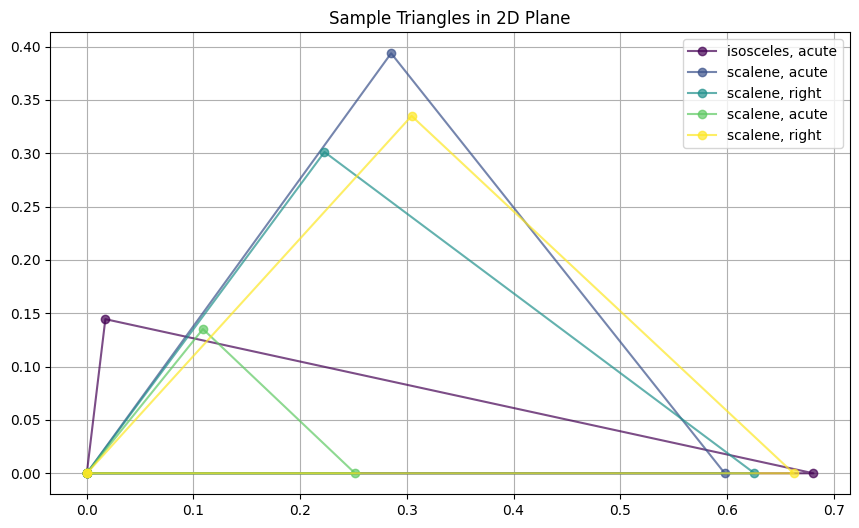

In [3]:
import matplotlib.pyplot as plt

def plot_triangle(a, b, c, ax, label=None, color='blue'):
    """
    Plot a triangle in 2D given side lengths a, b, c.
    Triangle ABC with:
        A at (0, 0),
        B at (c, 0),
        C determined by cosine law from a, b, c
    """
    # Fixed base AB
    A = np.array([0, 0])
    B = np.array([c, 0])
    
    # Use law of cosines to find angle at C
    cos_angle = (a**2 + c**2 - b**2) / (2 * a * c)
    cos_angle = np.clip(cos_angle, -1, 1)  # numerical safety
    angle = np.arccos(cos_angle)
    
    # Coordinates of C using polar transformation from A
    C = np.array([a * np.cos(angle), a * np.sin(angle)])
    
    triangle = np.array([A, B, C, A])
    ax.plot(triangle[:, 0], triangle[:, 1], marker='o', color=color, label=label, alpha = 0.7)
    ax.set_aspect('equal')

def visualize_sample_triangles(df, n=5):
    """
    Visualize n triangles from the dataframe.
    """
    _, ax = plt.subplots(figsize=(12, 6))
    sample = df.sample(n=n)
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    
    for i, row in enumerate(sample.itertuples()):
        plot_triangle(row.a, row.b, row.c, ax, label=f"{row.side_type}, {row.angle_type}", color=colors[i])
    
    ax.legend()
    ax.set_title("Sample Triangles in 2D Plane")
    plt.grid(True)
    plt.show()

# Visualize a few triangles
visualize_sample_triangles(dataset_df, n=5)


Now we have a good understanding of our dataset, finally in this section we define an appropriate PyTorch dataset and -loader.  
Then, in the next section, we will focus on the actual diffusion model.

## Diffusion model

We will utilize a similar OU diffusion process for our diffusion model as in the first post.   
In this post we mainly skip the modeling parts and focus on fine tuning our trained model, therefore we shall use code stored in a separate python module to do the heavy lifting for us.

In [4]:
# Diffusion model parameters
lambda_coeff = 0.4
sigma_coeff = 0.5 # constant scale for diffusion process

# Discretization parameters
delta_t = 0.01

In [5]:
# Generating a sample and visualize it
sample = generate_trajectory(initial_pos=dataset_df[['a', 'b', 'c']].values, delta_t = 0.001, t = 1.0, f = lambda x, t: -lambda_coeff * x, g= lambda t: sigma_coeff)
trajectory = np.asarray([s[0] for s in sample])

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Multiple 1D Diffusion Trajectories'}, xlabel='Time', ylabel='x(t)'>)

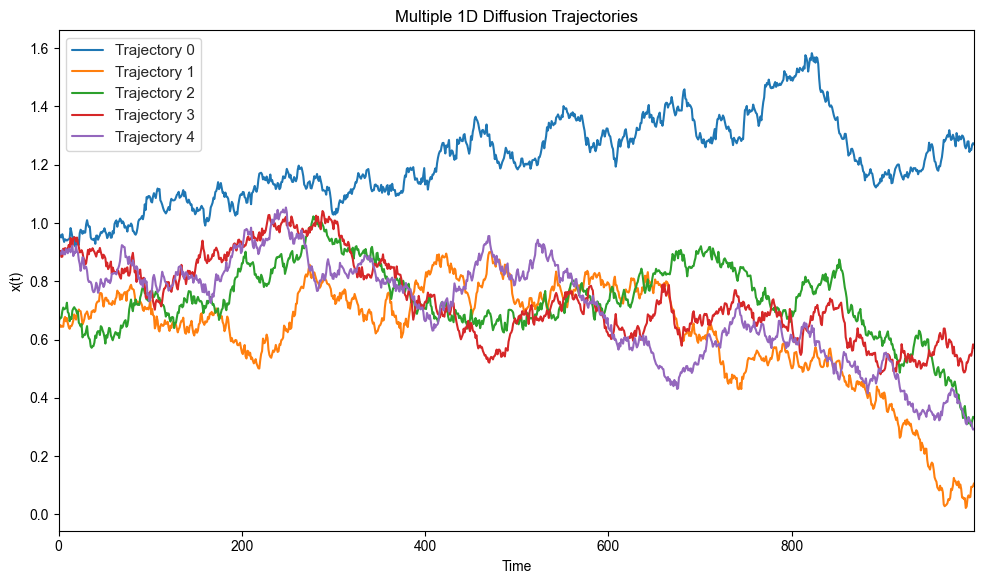

In [6]:
plot_multiple_1d_trajectories(trajectory[:, :5, 2])

### Training dataset

Now we define an iterable dataset for the diffusion model, the dataset contains tuples $(x, t, \nabla_x p_t(x))$.  
In other words, the iterable dataset generates samples $x \sim X_t$ from the diffusion process from the starting set of triangles. Alonside the samples, we compute the correct value for the gradient of the density $p_t(x)$.

In [8]:
from diffusion_on_the_edge.ou_dataset import OUDiffusionDatasetVectorized 

In [9]:
dataset = OUDiffusionDatasetVectorized(torch.from_numpy(dataset_df[['a', 'b', 'c']].to_numpy()), T_max=1.0, lam = lambda_coeff, sigma = sigma_coeff, batch_size=32, batches_per_epoch=10)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=None)

In [10]:
# Defining a model
model = SimpleScoreNet(input_dimesion=4, output_dimension=3, layer_count=1, hidden_dim=16)

In [ ]:
# Train the scoring model on the triangle dataset
EPOCHS = 1
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        

{'t': tensor([0.6586, 0.1379, 0.2234, 0.6949, 0.3954, 0.3866, 0.0341, 0.5007, 0.2083,
        0.0030, 0.5446, 0.5783, 0.6188, 0.3872, 0.9637, 0.2315, 0.7140, 0.2128,
        0.9003, 0.1713, 0.5662, 0.6546, 0.2234, 0.7559, 0.5584, 0.6088, 0.9069,
        0.2416, 0.1446, 0.0787, 0.8798, 0.9817]), 'x0': tensor([[0.3166, 0.6192, 0.7081],
        [0.2608, 0.7992, 0.8080],
        [0.3333, 0.4035, 0.4919],
        [0.0487, 0.5878, 0.6224],
        [0.5464, 0.7049, 0.8171],
        [0.7278, 0.8441, 0.8508],
        [0.1455, 0.6793, 0.6811],
        [0.5361, 0.7392, 0.8188],
        [0.6007, 0.7436, 0.9505],
        [0.2340, 0.6324, 0.6363],
        [0.6821, 0.7050, 0.8725],
        [0.5551, 0.5766, 0.6189],
        [0.3289, 0.5187, 0.5195],
        [0.3668, 0.4802, 0.5717],
        [0.0802, 0.6165, 0.6348],
        [0.1337, 0.6356, 0.6626],
        [0.3803, 0.4764, 0.5053],
        [0.1689, 0.1770, 0.2786],
        [0.2305, 0.7719, 0.7808],
        [0.2199, 0.2459, 0.2728],
        [0.1398, 0